In [1]:
%load_ext autoreload
%autoreload 2

# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Prepare dataset
We'll be working on MNIST dataset

In [2]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms

mean, std = 0.28604059698879553, 0.35302424451492237
batch_size = 256

train_dataset = FashionMNIST('../data/FashionMNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = FashionMNIST('../data/FashionMNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))

cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

n_classes = 10

## Common setup

In [3]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

fashion_mnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
mnist_classes = fashion_mnist_classes

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

## Steps
1. Create a dataset returning triplets - **TripletMNIST** class from *datasets.py*, wrapper for MNIST-like classes
2. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
3. Define **triplet** network processing triplets - **TripletNet** wrapping *EmbeddingNet*
4. Train the network with **TripletLoss** - *losses.py*

In [ ]:
# Set up data loaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 500

In [ ]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.999715
Epoch: 1/20. Train set: Average loss: 0.1918
Epoch: 1/20. Validation set: Average loss: 0.1520
Train: [0/60000 (0%)]	Loss: 0.156159
Epoch: 2/20. Train set: Average loss: 0.1383
Epoch: 2/20. Validation set: Average loss: 0.1393
Train: [0/60000 (0%)]	Loss: 0.063343
Epoch: 3/20. Train set: Average loss: 0.1184
Epoch: 3/20. Validation set: Average loss: 0.1153
Train: [0/60000 (0%)]	Loss: 0.094688
Epoch: 4/20. Train set: Average loss: 0.1064
Epoch: 4/20. Validation set: Average loss: 0.1102
Train: [0/60000 (0%)]	Loss: 0.105735
Epoch: 5/20. Train set: Average loss: 0.0963
Epoch: 5/20. Validation set: Average loss: 0.1131
Train: [0/60000 (0%)]	Loss: 0.041875
Epoch: 6/20. Train set: Average loss: 0.0904
Epoch: 6/20. Validation set: Average loss: 0.1017
Train: [0/60000 (0%)]	Loss: 0.065105
Epoch: 7/20. Train set: Average loss: 0.0818
Epoch: 7/20. Validation set: Average loss: 0.1001
Train: [0/60000 (0%)]	Loss: 0.062069
Epoch: 8/20. Train set: Average loss: 0

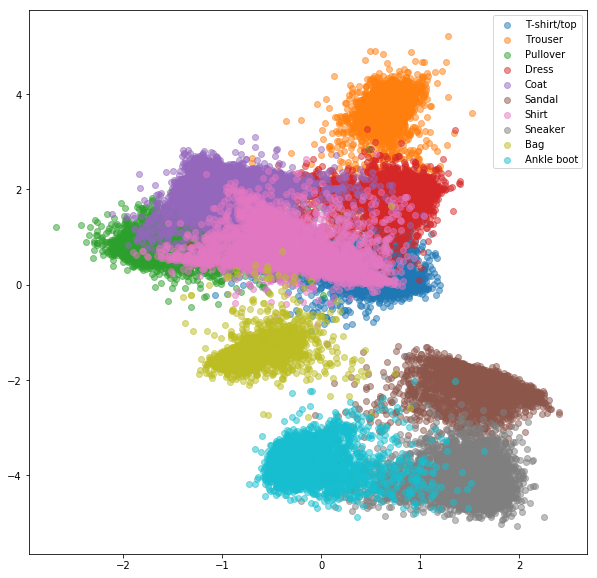

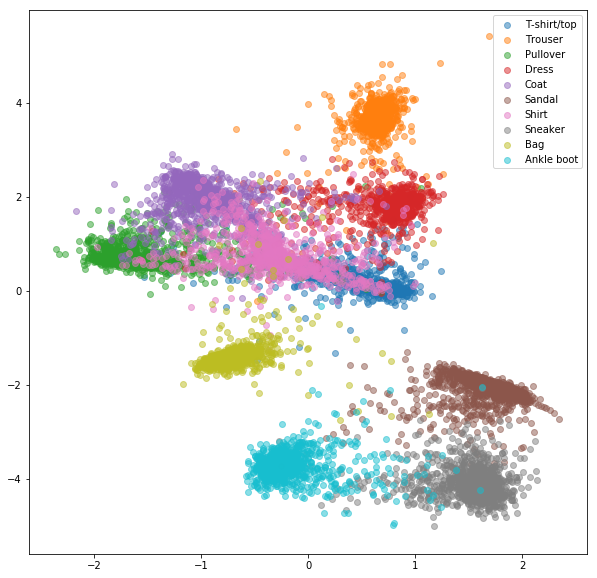

In [ ]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)